# Figures

In here, all the main figures are plotted

In [1]:
import numpy as np
import pandas as pd
from ridgeplot import ridgeplot

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'notebook'
from graphmodex import plotlymodex

import matplotlib.pyplot as plt
import seaborn as sns

from bumplot import bumplot

# Data & Config

In [2]:
# ===============================
# CONFIG
# ===============================
steps_per_day = 8
two_year_steps = 2 * 365 * steps_per_day
target_windows = 30

FREQ = '3h'
SEASON_LENGTH = 8 

pollutants_dict = {
        'go3': {
            'scaler': 1e8
        },
        'no2': {
            'scaler': 1e10
        },
        'pm10': {
            'scaler': 1e9
        },
        'pm2p5': {
            'scaler': 1e9
        },
    }
experiments_dict = {
    '1 days': {
        'horizon': 8*1,
        'step_size': max(8*1, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '7 days': {
        'horizon': 8*7,
        'step_size': max(8*7, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '14 days': {
        'horizon': 8*14,
        'step_size': max(8*14, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '30 days': {
        'horizon': 8*30,
        'step_size': 8*30,
        'windows': two_year_steps // (8*30),  # 24
    },
}

database_full = pd.read_csv(r'.\Results\RQ1\full\go3_1days.csv')
database_full = database_full.query("NHITS.notna()")

metrics = pd.read_csv(r'.\Results\RQ1\metrics.csv')
del metrics['Unnamed: 0']

# Forecasting

In [4]:
def plot_pollutant_forecasting(
        poll='go3',
        h=1,
        uid=0,
        models={
            'NHITS': "#287eb8",
            'NBEATS-G': "#72a549",
            'NBEATS-I': "#d4bc34",
            'LightGBM': "#6c34d4",
            'Naive': "#d43f34",
            'SeasonalNaive': "#d4347f",
        },
        horizon=None  # Adicionando o parâmetro horizon
    ):

    series = pd.read_parquet(rf'.\Results\RQ1\full\{poll}.parquet')

    df = pd.read_csv(rf'.\Results\RQ1\full\{poll}_{str(h)}days.csv')
    # df = df.query("NHITS.notna()")
    df = df.rename(columns={'valid_time': 'ds'})
    df = df.astype({
        'ds': 'datetime64[ns]',
        'cutoff': 'datetime64[ns]',
    })

    cutoffs = df['cutoff'].unique() 

    # ==================================================
    # REAL SERIE
    # ==================================================
    fig = go.Figure()

    pollutant_filt = series.copy().query(
        "ds >= '2022-06-01' and unique_id == @uid"
    )

    fig.add_trace(
        go.Scatter(
            x=pollutant_filt['ds'],
            y=pollutant_filt['y'],
            mode='lines',
            line=dict(color='black', width=2),
            name='Real'
        )
    )

    # ==================================================
    # MODELS — ONE WINDOW PER CUTOFF
    # ==================================================
    for model, color in models.items():
        show_legend_ = True
        for cutoff in cutoffs:

            df_fold = df.query(
                "unique_id == @uid and cutoff == @cutoff"
            )

            if df_fold.empty:
                continue

            # Linha da previsão (segmento independente)
            fig.add_trace(
                go.Scatter(
                    x=df_fold['ds'],
                    y=df_fold[model],
                    mode='lines',
                    line=dict(color=color, width=2),
                    marker=dict(color=color, size=5),
                    opacity=0.75,
                    name=model,
                    showlegend=show_legend_
                )
            )

            show_legend_ = False

    # ==================================================
    # CUTOFFS VERTICAL LINES
    # ==================================================
    for cutoff in cutoffs:
        fig.add_vline(
            x=cutoff + pd.Timedelta(hours=3),
            line_width=1,
            line_dash="dot",
            line_color="black",
            opacity=0.5
        )
        if horizon is not None:  # Usando o horizonte fornecido como parâmetro
            fig.add_vline(
                x=cutoff + pd.Timedelta(hours=3 * horizon),
                line_width=1,
                line_dash="dot",
                line_color="black",
                opacity=0.5
            )

    # ==================================================
    # FINAL LAYOUT
    # ==================================================
    plotlymodex.main_layout(
        fig, width=1200, height=600,
        x=r"$\mathrm{time_{\ freq: 3 h}}$",
        y=r"$\mathrm{kg\ kg^{-1}}$",
        title='Pollutant Forecasting | Cross-Validation Windows'
    )

    fig.update_layout(
        legend_title_text='Series',
        hovermode='x unified',

        # Fonte global
        font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        ),

        # Eixo X
        xaxis=dict(
            showgrid=False, zeroline=False,
            title_font=dict(family="Times New Roman"),
            tickfont=dict(family="Times New Roman")
        ),

        # Eixo Y
        yaxis=dict(
            zeroline=False,
            title_font=dict(family="Times New Roman"),
            tickfont=dict(family="Times New Roman")
        ),
    )

    fig.update_layout(
        # Margens bem mais compactas
        margin=dict(
            l=60,
            r=10,
            t=60, 
            b=50
        ),

        # Título mais compacto
        title=dict(
            y=0.97,
            yanchor='top'
        )
    )

    fig.update_layout(
        legend=dict(
            x=0.01,      # esquerda
            y=0.99,      # topo
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.7)',  # opcional
            bordercolor='black',              # opcional
            borderwidth=2                     # opcional
        )
    )

    return fig

In [9]:
# Exemplo de chamada da função para um dado modelo e cutoff
models = {
    'NHITS': "#287eb8",
    'NBEATS-G': "#72a549",
    'NBEATS-I': "#d4bc34",
    'LightGBM': "#6c34d4",
    'GRU': "#d43f34",
    'LSTM': "#d46f34",
    # 'SeasonalNaive-8': "#d4347f",
}

# Chamada da função com o ID único, cutoffs e modelos
plot_pollutant_forecasting(
    poll='no2',
    h=30,
    uid=54,
    models=models,
)

# **RQ1**

## sMAPE Ridge

In [ ]:
# Version with Gradient

def plot_ridge_metrics(h : str = '30', metric: str = 'sMAPE', agg_func: str = 'median'):

    # ===============================
    # DATA PREPARATION
    # ===============================

    df_plot = metrics.dropna(subset=[metric])

    median_smape = (
        df_plot
        .query(f"horizon == '{h}days'")
        .groupby("model")[metric]
        .agg(agg_func)
        .sort_values()
    )

    ordered_models = median_smape.index.tolist()

    samples = [
        df_plot.loc[df_plot["model"] == m, metric].values
        for m in ordered_models
    ]

    labels = ordered_models


    # ===============================
    # RIDGEPLOT
    # ===============================

    fig = ridgeplot(samples=samples, labels=labels)

    for tr in fig.data:
        tr.showlegend = False

    plotlymodex.main_layout(
        fig,
        title=f"Distribution of {h}-Day-Ahead {metric} by Model (Ordered by {agg_func.capitalize()} Performance)",
        width=1000,
        height=700,
        x=f"{metric}↓",
        y=None
    )

    fig.update_layout(font=dict(family="Times New Roman", size=16))


    # ===============================
    # CUSTOM Y-AXIS LABELS
    # ===============================

    yvals = list(fig.layout.yaxis.tickvals)

    fig.update_yaxes(showticklabels=False)

    NAME_SHIFT = 0
    MU_SHIFT = -15

    for y, m in zip(yvals, ordered_models):

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{m}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=16),
            yshift=NAME_SHIFT
        )

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{agg_func.capitalize()} = {median_smape[m]:.3f}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=12),
            yshift=MU_SHIFT
        )

    fig.update_layout(
        margin=dict(l=140, r=40, t=50, b=60),
        title=dict(y=0.97, yanchor="top")
    )


    # ===============================
    # MODEL FAMILIES
    # ===============================

    neural_models = ["NBEATS-I", "NBEATS-G", "NHITS"]
    ml_models = ["LightGBM", "RandomForest", "XGBoost"]
    stat_models = ["Arima", "ETS", "Theta"]
    benchmark_models = ["Naive", "SeasonalNaive-8", "SeasonalNaive-56"]
    dl_models = ["GRU", "LSTM", "Informer"]


    # ===============================
    # COLOR GRADIENT MAP
    # ===============================

    family_gradients = {
        "neural": ["#D62121", "#ECD449", "#ECD449"],
        "ml": ["#00B17A", "#3676AA", "#6D2DA8"],
        "stat": ["#BD5CE4", "#38C4DD", "#38C4DD"],
        "benchmark": ["#707070", "#E7E7E7", "#E7E7E7"],
        "dl": ["#DD7DCD", "#CF5C9F", "#DA4444"],
    }
  
 
    # ===============================
    # FAMILY IDENTIFICATION
    # ===============================

    def get_family(model):
        if model in neural_models:
            return "neural"
        elif model in ml_models:
            return "ml"
        elif model in stat_models:
            return "stat"
        elif model in benchmark_models:
            return "benchmark"
        elif model in dl_models:
            return "dl"
        else:
            return None


    def build_colorscale(anchor_colors):
        colors = plotlymodex.list_colors(
            n=20,
            colors=anchor_colors,
            weights=[0, 0.5, 1]
        )
        return [[i/(len(colors)-1), c] for i, c in enumerate(colors)]


    # ===============================
    # APPLY GRADIENTS
    # ===============================

    for trace in fig.data:

        if trace.fill == "tonexty":

            model = trace.name
            family = get_family(model)

            if family is not None:

                anchors = family_gradients[family]

                trace.fillgradient = dict(
                    type="horizontal",
                    colorscale=build_colorscale(anchors)
                )

    fig.update_xaxes(
        showgrid=True,
        gridwidth=0.4,
        gridcolor="rgba(0,0,0,0.07)"
    )
    fig.update_xaxes(range=[0, 1.5])
    fig.update_yaxes(showgrid=False)

    for trace in fig.data:
        trace.line.width = 1

    fig.show()

In [20]:
# Defined Colors Version

def plot_ridge_metrics(h: str = '30', metric: str = 'sMAPE', agg_func: str = 'median'):

    # ===============================
    # DATA PREPARATION
    # ===============================

    df_plot = metrics.dropna(subset=[metric])

    median_smape = (
        df_plot
        .query(f"horizon == '{h}days'")
        .groupby("model")[metric]
        .agg(agg_func)
        .sort_values()
    )

    ordered_models = median_smape.index.tolist()

    samples = [
        df_plot.loc[df_plot["model"] == m, metric].values
        for m in ordered_models
    ]

    labels = ordered_models


    # ===============================
    # RIDGEPLOT
    # ===============================

    fig = ridgeplot(samples=samples, labels=labels)

    for tr in fig.data:
        tr.showlegend = False

    plotlymodex.main_layout(
        fig,
        title=f"Distribution of {h}-Day-Ahead {metric} by Model (Ordered by {agg_func.capitalize()} Performance)",
        width=1000,
        height=700,
        x=f"{metric}↓",
        y=None
    )

    fig.update_layout(font=dict(family="Times New Roman", size=16))


    # ===============================
    # CUSTOM Y-AXIS LABELS
    # ===============================

    yvals = list(fig.layout.yaxis.tickvals)

    fig.update_yaxes(showticklabels=False)

    NAME_SHIFT = 0
    MU_SHIFT = -15

    for y, m in zip(yvals, ordered_models):

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{m}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=16),
            yshift=NAME_SHIFT
        )

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{agg_func.capitalize()} = {median_smape[m]:.3f}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=12),
            yshift=MU_SHIFT
        )

    fig.update_layout(
        margin=dict(l=140, r=40, t=50, b=60),
        title=dict(y=0.97, yanchor="top")
    )


    # ===============================
    # MODEL FAMILIES
    # ===============================

    neural_models = ["NBEATS-I", "NBEATS-G", "NHITS"]
    ml_models = ["LightGBM", "RandomForest", "XGBoost"]
    stat_models = ["Arima", "ETS", "Theta"]
    benchmark_models = ["Naive", "SeasonalNaive-8", "SeasonalNaive-56"]
    dl_models = ["GRU", "LSTM", "Informer"]


    # ===============================
    # COLOR MAP (Correção no formato da cor com transparência)
    # ===============================

    color_map = {
        'Neural': "rgba(233, 163, 58, 0.67)",  
        'ML': 'rgba(106, 160, 64, 0.67)',      
        'Stats': 'rgba(92, 200, 230, 0.67)',   
        'Benchmark': 'rgba(201, 201, 201, 0.67)',
        'DL': 'rgba(224, 31, 102, 0.5)',
        'Other': 'rgba(0, 0, 0, 1)'             
    }

    # ===============================
    # FAMILY IDENTIFICATION
    # ===============================

    def get_family(model):
        if model in neural_models:
            return "Neural"
        elif model in ml_models:
            return "ML"
        elif model in stat_models:
            return "Stats"
        elif model in benchmark_models:
            return "Benchmark"
        elif model in dl_models:
            return "DL"
        else:
            return "Other"


    # ===============================
    # APPLY FIXED COLORS & FILLS
    # ===============================

    for trace in fig.data:
        # 1. Identificamos se o traço é uma curva (possui nome)
        if trace.name is not None:
            model = trace.name
            family = get_family(model)
            family_color = color_map.get(family, color_map["Other"])

            # 2. Forçar contorno preto e largura
            trace.line.color = 'black'
            trace.line.width = 1.5
            
            # 3. Remover o gradiente para que a fillcolor funcione
            if 'fillgradient' in trace:
                trace.fillgradient = None
            
            # 4. Definir preenchimento sólido com a cor da família
            trace.fill = 'toself'
            trace.fillcolor = family_color
            
        else:
            # Estes são os traços da "base" (linhas horizontais pretas)
            # Se você quiser que eles sumam ou fiquem mais sutis:
            trace.line.width = 1
            trace.line.color = 'rgba(0,0,0,0.3)' # Deixa a base semi-transparente

    fig.update_xaxes(
        showgrid=True,
        gridwidth=0.4,
        gridcolor="rgba(0,0,0,0.07)"
    )
    fig.update_xaxes(range=[0, 1.5])
    fig.update_yaxes(showgrid=False)

    for trace in fig.data:
        trace.line.width = 0.8  

    return fig


In [21]:
plot_ridge_metrics(h=1, metric='sMAPE', agg_func='median').show()
plot_ridge_metrics(h=7, metric='sMAPE', agg_func='median').show()
plot_ridge_metrics(h=14, metric='sMAPE', agg_func='median').show()
plot_ridge_metrics(h=30, metric='sMAPE', agg_func='median').show()

## BumPlot

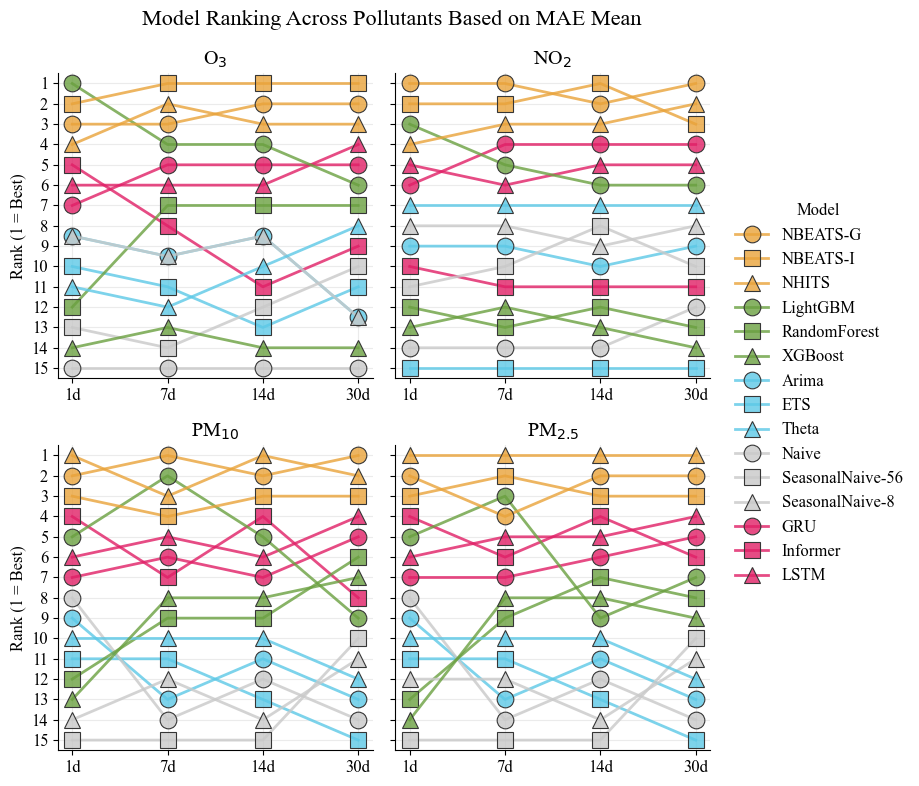

In [24]:
def plot_bump_all_pollutants(metrics, pollutants, metric="MAE", agg_func: str = 'mean'):

    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 12
    })

    model_category = {
        'NHITS': 'Neural',
        'NBEATS-I': 'Neural',
        'NBEATS-G': 'Neural',
        'LightGBM': 'ML',
        'RandomForest': 'ML',
        'XGBoost': 'ML',
        'Theta': 'Stats',
        'Arima': 'Stats',
        'ETS': 'Stats',
        'Naive': 'Benchmark',
        'SeasonalNaive-8': 'Benchmark',
        'SeasonalNaive-56': 'Benchmark',
        'GRU': 'dl',
        'LSTM': 'dl',
        'Informer': 'dl',
    }

    color_map = {
        'Neural': "#e9a33acc",
        'ML': '#6aa040cc',
        'Stats': '#5cc8e6cc',
        'Benchmark': "#c9c9c9cc",
        'dl': "#e01f66cc",
        'Other': '#000000'
    }

    category_markers = ['o', 's', '^']

    # ==============================
    # PREPARE DATA (once)
    # ==============================

    df = (
        metrics
        .groupby(["pollutant", "horizon", "model"], observed=False)[metric]
        .agg(agg_func)
        .reset_index()
    )

    df["horizon"] = df["horizon"].str.replace("days", "", regex=False)
    df["horizon"] = df["horizon"].astype(int)

    horizons = sorted(df["horizon"].unique())
    horizon_labels = [f"{h}d" for h in horizons]
    x_numeric = np.arange(len(horizons))

    # ==============================
    # CREATE SUBPLOTS
    # ==============================

    fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
    axes = axes.flatten()

    handles = []
    labels = []

    for ax, pollutant in zip(axes, pollutants):

        pollutant_display = {
            "no2": r"NO$_2$",
            "pm10": r"PM$_{10}$",
            "pm2p5": r"PM$_{2.5}$",
            "go3": r"O$_{3}$",
        }

        df_pol = df[df["pollutant"] == pollutant].copy()
        df_pol = df_pol.sort_values("horizon")

        df_pol["rank"] = (
            df_pol
            .groupby("horizon", observed=False)[metric]
            .rank(method="average", ascending=True)
        )

        df_bump = (
            df_pol[["model", "horizon", "rank"]]
            .pivot(index="horizon", columns="model", values="rank")
            .reindex(horizons)
        )

        models = df_bump.columns.tolist()
        category_counter = {}

        for model in models:

            category = model_category.get(model, "Other")
            color = color_map.get(category, "#000000")

            if category not in category_counter:
                category_counter[category] = 0

            marker = category_markers[
                category_counter[category] % len(category_markers)
            ]
            category_counter[category] += 1

            y = df_bump[model].values

            line, = ax.plot(
                x_numeric,
                y,
                label=model,
                color=color,
                linewidth=2,
                marker=marker,
                markersize=12,
                markeredgecolor="#363636",
                markeredgewidth=0.8
            )

            # capture legend only once
            if pollutant == pollutants[0]:
                handles.append(line)
                labels.append(model)

        ax.set_title(pollutant_display.get(pollutant, pollutant.upper()))

        ax.set_xticks(x_numeric)
        ax.set_xticklabels(horizon_labels)
        ax.invert_yaxis()
        ax.grid(alpha=0.25)
        ax.spines[["top", "right"]].set_visible(False)

    max_rank = int(
        df.groupby(["pollutant", "horizon"], observed=False)[metric]
        .rank(method="average", ascending=True)
        .max()
    )
    for ax in axes:
        ax.set_ylim(max_rank + 0.5, 0.5)  # força 1 no topo
        ax.set_yticks(range(1, max_rank + 1))

    axes[0].set_ylabel("Rank (1 = Best)")
    axes[2].set_ylabel("Rank (1 = Best)")
    
    # Define ordem desejada das categorias
    category_order = {
        "Neural": 0,
        "ML": 1,
        "Stats": 2,
        "Benchmark": 3,
        "Other": 4
    }

    # Cria lista combinada
    legend_items = list(zip(handles, labels))

    # Ordena baseado na categoria do modelo
    legend_items.sort(
        key=lambda x: category_order.get(model_category.get(x[1], "Other"), 4)
    )

    # Separa novamente
    handles_sorted, labels_sorted = zip(*legend_items)

    fig.legend(
        handles_sorted,
        labels_sorted,
        title="Model",
        bbox_to_anchor=(0.91, 0.5),
        loc="center left",
        frameon=False
    )

    fig.suptitle(
        f"Model Ranking Across Pollutants Based on {metric} {agg_func.capitalize()}",
        fontsize=16,
        y=0.98
    )

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()

    return fig, axes

plot_bump_all_pollutants(
    metrics,
    pollutants=["go3", "no2", "pm10", "pm2p5"],
    metric="MAE", 
    agg_func='mean'
);

## Ranking Bubble Plot

In [36]:
metrics_ = metrics.copy()

# ==========================================
# NOVO: FILTRO DE MODELOS
# ==========================================
# Liste aqui apenas os modelos que você quer que apareçam
models_to_keep = [
    'NHITS', 'NBEATS-G', 'NBEATS-I', 
    'GRU', 'LSTM', 'Informer',
    'LightGBM', 'RandomForest', 'XGBoost',
    'Arima', 'ETS', 
    'Naive', 
] 

# Aplicando o filtro
metrics_ = metrics_[metrics_['model'].isin(models_to_keep)]
# ==========================================

# 1. Mapeamento EXATO e Internacionalização das Categorias
model_to_group = {
    'NHITS': 'Neural', 'NBEATS-G': 'Neural', 'NBEATS-I': 'Neural',
    'LightGBM': 'ML', 'RandomForest': 'ML', 'XGBoost': 'ML',
    'Arima': 'Statistical', 'ETS': 'Statistical', 'Theta': 'Statistical',
    'Naive': 'Benchmark', 'SeasonalNaive-56': 'Benchmark', 'SeasonalNaive-8': 'Benchmark',
    'GRU': 'dl', 'LSTM': 'dl', 'Informer': 'dl',
}
# ... o restante do seu código segue igual

group_colors = {
    'Neural': "#e9a33a",
    'ML': "#6aa040",
    'Statistical': '#5cc8e6',
    'Benchmark': "#C9C9C9",
    'dl': "#e01f66",
}

# Gerando o ranking
metrics_['ranking'] = metrics_.groupby(['pollutant', 'horizon', 'unique_id', 'cutoff'])['MAE'].rank(method='dense', ascending=True)
metrics_ = metrics_.groupby(['horizon', 'model', 'ranking']).agg({
    'pollutant': 'count'
}).reset_index()

# 2. Mapeando Grupos e Cores
metrics_['group'] = metrics_['model'].map(model_to_group)
metrics_['color'] = metrics_['group'].map(group_colors)

# 3. Ordenação dos Modelos (Neural -> ML -> Statistical -> Benchmark)
group_order = ['Neural', 'dl', 'ML', 'Statistical', 'Benchmark',]
metrics_['group'] = pd.Categorical(metrics_['group'], categories=group_order, ordered=True)
metrics_ = metrics_.sort_values(by=['group', 'model'], ascending=[False, True])

# Ordenação dos Horizontes
horizon_order = ['1days', '7days', '14days', '30days']
unique_horizons = [h for h in horizon_order if h in metrics_['horizon'].unique()]

figs = []

for horizon in unique_horizons:
    horizon_data = metrics_[metrics_['horizon'] == horizon]
    
    fig_item = go.Figure()
    fig_item.add_trace(go.Scatter(
        x=horizon_data['ranking'], 
        y=horizon_data['model'], 
        mode='markers+text', # ATUALIZADO: markers + texto
        name=horizon,
        marker=dict(
            size=70 * horizon_data['pollutant'] / horizon_data['pollutant'].max() if not horizon_data.empty else 10, 
            color=horizon_data['color'],
            opacity=0.7,
            line=dict(width=0.8, color='black')
        ),
        text=horizon_data['pollutant'], # ATUALIZADO: Mostra a contagem
        textposition="middle center",   # Centraliza o número na bolha
        textfont=dict(
            family="Times New Roman",
            size=10,
            color="black"
        )
    ))
    
    fig_item.update_yaxes(categoryorder='array', categoryarray=metrics_['model'].unique()[::-1])
    figs.append(fig_item)

# Gerando o subplot final
fig_final = plotlymodex.subplot(
    figs=figs, 
    title='Model Ranking Distribution by Forecasting Horizon',
    cols=2, rows=2,
    height=1100, width=1300,
    shared_yaxes=True,
    subplot_titles=['1-Day-Ahead Forecasting', '7-Days-Ahead Forecasting', 
                    '14-Days-Ahead Forecasting', '30-Days-Ahead Forecasting'],
    horizontal_spacing=0.05, 
    legends=[0, 0, 0, 0]
)

# ===============================
# PUBLICATION STYLE ADJUSTMENTS
# ===============================

fig_final.update_layout(
    font=dict(family="Times New Roman", size=15, color="black"),
    title=dict(font=dict(size=22)),
    plot_bgcolor='white'
)

# X Range fixado para clareza
max_rank = metrics_['ranking'].max() + 0.5

fig_final.update_xaxes(
    range=[0.1, max_rank+0.4], 
    title_text="Ranking Position", 
    dtick=1, 
    showgrid=True, 
    gridcolor='rgba(0,0,0,0.1)',
    linecolor='black',
    mirror=True
)

for i in [1, 2]:
    fig_final.layout[f'xaxis{i}'].title.text = ""

fig_final.update_yaxes(
    title_text=None,
    showgrid=True,
    gridcolor='rgba(0,0,0,0.05)',
    linecolor='black',
    mirror=True
)

fig_final.update_layout(margin=dict(l=120, r=40, t=70, b=60))

fig_final.show()

## Metric BoxPlot

In [37]:
def plot_boxplot_metrics(horizons: list = ['1', '7', '14', '30'], 
                         metric: str = 'sMAPE',
                         models: list = None,
                         colors: list = ["#B3C7F9", "#6B8EF6", "#365FCE", "#1D2E91"],
                         x_range: list = [0, 30e-9]):

    # ===============================
    # DATA PREPARATION
    # ===============================
    df_plot = metrics.dropna(subset=[metric])

    if models:
        df_plot = df_plot[df_plot['model'].isin(models)]

    df_plot = df_plot[df_plot['horizon'].isin([f'{h}days' for h in horizons])]

    # ===============================
    # COLOR SCALE
    # ===============================
    horizon_color_map = {str(h): colors[i] for i, h in enumerate(horizons)}

    # ===============================
    # BOXPLOT
    # ===============================
    box_data = []

    # Removido o reversed para a legenda seguir a ordem natural 1 -> 30
    for horizon_idx, horizon in enumerate(list(reversed(horizons))): 
        horizon_data = df_plot[df_plot['horizon'] == f'{horizon}days']
        
        current_color = horizon_color_map[horizon]

        box_data.append(
            go.Box(
                x=horizon_data[metric],
                y=horizon_data['model'],
                name=f'{horizon}days',
                boxmean='sd',
                # Define a cor da CAIXA e das linhas (whiskers/median)
                line=dict(color=current_color),
                # Define a cor apenas dos PONTOS (outliers)
                marker=dict(
                    color='lightgrey', 
                    opacity=0.5, 
                    size=7
                ),
                orientation='h',
                pointpos=0,
                offsetgroup=horizon_idx,
                boxpoints='suspectedoutliers',
                jitter=0.1,
            )
        )

    # ===============================
    # LAYOUT
    # ===============================
    fig = go.Figure(data=box_data)

    fig.update_layout(
        title=f'Boxplot of {metric} by Model and Horizon',
        xaxis_title=f'{metric} ↓',
        yaxis_title=None,
        boxmode='group',
        boxgap=0.1,
        boxgroupgap=0.1,
        font=dict(family="Times New Roman", size=16),
        # Fixando range em 0 para o SD não vazar para o negativo
        xaxis=dict(
            showgrid=True, 
            gridwidth=0.4, 
            gridcolor="rgba(0,0,0,0.07)",
            range=[0, None] 
        ),
        yaxis=dict(
            showgrid=False, 
            showticklabels=True, 
            autorange=True, 
            categoryorder='array',
            categoryarray=models  # Garantir a ordem dos modelos conforme o input
        ), 
        margin=dict(l=100, r=40, t=50, b=60),
        showlegend=True,
    )

    # Caso use o seu wrapper personalizado:
    if 'plotlymodex' in globals():
        plotlymodex.main_layout(
            fig, title=f'Boxplot of {metric} by Model and Horizon',
            width=1000, height=800,
            x=f'{metric}↓', y=None,
            x_range=x_range,
            # x_type='log'
        )
    
    fig.show()

In [41]:
plot_boxplot_metrics(
    ['1', '7', '14', '30'], 
    models=[
        'Naive', 
        'Informer', 
        'GRU', 
        'LSTM',
        'LightGBM', 
        'NBEATS-I', 'NBEATS-G', 'NHITS', 
    ],
    metric='MAE',
    colors=plotlymodex.list_colors(n=4, colors=["#afd6eb", "#336db9", "#073f6d"], weights=[0, 0.7, 1]),
)

# **RQ2**